<img src="images/arm_logo.png" width=500 alt="ARM Logo"></img>

# NOAA Multi-Radar / Multi-Sensor System (MRMS)
## Hourly QPE BNF Mosaic

The [NOAA Multi-Radar / Multi-Sensor System (MRMS)](https://www.nssl.noaa.gov/projects/mrms/) was created to produce products of preciptiation impacts on transportation and aviation. 

Using the [NOAA MRMS AWS Bucket](https://aws.amazon.com/marketplace/pp/prodview-6odvdc4md2jjc), this notebook details creation of quicklooks to investigate a Quantitative Preciptiation Estimates (QPE) for the AMF-3 Deployment to Bankhead National Forest. 

In [78]:
import cfgrib
import xarray as xr
import fsspec
import glob
import tempfile
import gzip
import geopandas as gpd
import pandas as pd
import numpy as np
import warnings

from cartopy import feature as cfeature
from cartopy.io.img_tiles import OSM
from matplotlib.transforms import offset_copy
from matplotlib import pyplot as plt

from metpy.plots import USCOUNTIES

import cmweather

# To ignore all RuntimeWarnings globally
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Default Configuration

In [79]:
# Define a Date for Analysis [YYYYMMDD format]
DATE = "20250524"
HOUR = "000000"

In [80]:
# define the sites of interest
global_sites = {"M1" : [34.34525, -87.33842],
                "S4" : [34.46451, -87.23598],
                "S3" : [34.63080, -87.13311],
                "S20" : [34.65401, -87.29264],
                "S30" : [34.38501, -86.92757],
                "S40" : [34.17932, -87.45349]}

# define the center of the map to be the CSAPR2
central_lon = -87.13076
central_lat = 34.63080

# Define a domain to set the extent of the figures
bnf_domain = [272.0, 274.0, 34.1, 35.1]
chi_box = [271.9, 272.5, 41.6, 42.15]

## Define the MRMS QPE Buckets

Note the Multi-Sensor (i.e. gauge adjusted) QPE product is split into two categories (Pass 1 and Pass 2), which defines the gauge latency used to adjust radar dervied QPE. 

In [81]:
## Setup the AWS S3 filesystem
fs = fsspec.filesystem("s3", anon=True)

In [82]:
s3_multi_bucket = [f"s3://noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass1_00.00/{DATE}/*.gz"]

In [83]:
s3_pass2_bucket = [f"s3://noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass2_00.00/{DATE}/*.gz"]

In [84]:
s3_radar_bucket = [f"s3://noaa-mrms-pds/CONUS/RadarOnly_QPE_01H_00.00/{DATE}/*[0-9]0000.grib2.gz"]

In [85]:
ds_radar_list = []
ds_multi_list = []
ds_pass2_list = []

In [86]:
for scan in s3_multi_bucket:
    file_path = sorted(fs.glob(scan))
    for mrms in file_path:
        with fs.open(mrms, 'rb') as gzip_file:
            with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
                # Uncompress and read the file
                f.write(gzip.decompress(gzip_file.read()))
                ds = xr.load_dataset(f.name, decode_timedelta=False)
                # Parameters are stored as 'unknown'; meta data in filename
                ds = ds.rename({"unknown" : "multisensor_qpe_1hr"})
                ds["multisensor_qpe_1hr"].attrs["units"] = "mm"
                ds["multisensor_qpe_1hr"].attrs["long_name"] = "Precipitation Accumulation (1-Hr latency)"
                # Subset for the desired bounding box and take out all missing values
                ds = ds.sel(latitude=slice(bnf_domain[3], bnf_domain[2]), longitude=slice(bnf_domain[0], bnf_domain[1])).where(ds.multisensor_qpe_1hr > 0)
                ds_multi_list.append(ds)

In [87]:
for scan in s3_radar_bucket:
    file_path = sorted(fs.glob(scan))
    for mrms in file_path:
        with fs.open(mrms, 'rb') as gzip_file:
            with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
                # Uncompress and read the file
                f.write(gzip.decompress(gzip_file.read()))
                ds = xr.load_dataset(f.name, decode_timedelta=False)
                ds = ds.rename({"unknown" : "radar_qpe_1hr"})
                ds["radar_qpe_1hr"].attrs["units"] = "mm"
                ds["radar_qpe_1hr"].attrs["long_name"] = "Precipitation Accumulation"
                 # Subset for the desired bounding box and take out all missing values
                ds = ds.sel(latitude=slice(bnf_domain[3], bnf_domain[2]), longitude=slice(bnf_domain[0], bnf_domain[1])).where(ds.radar_qpe_1hr > 0)
                ds_radar_list.append(ds)

In [88]:
for scan in s3_pass2_bucket:
    file_path = sorted(fs.glob(scan))
    for mrms in file_path:
        with fs.open(mrms, 'rb') as gzip_file:
            with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
                # Uncompress and read the file
                f.write(gzip.decompress(gzip_file.read()))
                ds = xr.load_dataset(f.name, decode_timedelta=False)
                ds = ds.rename({"unknown" : "multisensor_qpe_pass2"})
                ds["multisensor_qpe_pass2"].attrs["units"] = "mm"
                ds["multisensor_qpe_pass2"].attrs["long_name"] = "Precipitation Accumulation (2-Hr latency)"
                # Subset for the desired bounding box and take out all missing values
                ds = ds.sel(latitude=slice(bnf_domain[3], bnf_domain[2]), longitude=slice(bnf_domain[0], bnf_domain[1])).where(ds.multisensor_qpe_pass2 > 0)
                ds_pass2_list.append(ds)

In [89]:
# Concatenate all hourly files into xarray datasets
ds_radar_merged = xr.concat(ds_radar_list, dim="time")
ds_multi_merged = xr.concat(ds_multi_list, dim="time")
ds_pass2_merged = xr.concat(ds_pass2_list, dim="time")

In [90]:
# Merge Radar, Multi-Sensor Pass 1 and Multi-Sensor Pass 2 QPE into single dataset
ds_merged = xr.merge([ds_radar_merged, ds_multi_merged, ds_pass2_merged])

In [91]:
# Calculate the Cumulative Distribution
radar_cumulative = ds_merged['radar_qpe_1hr'].cumsum(dim='time')
multisensor = ds_merged['multisensor_qpe_1hr'].cumsum(dim="time")
multisensor_pass2 = ds_merged['multisensor_qpe_pass2'].cumsum(dim="time")

ds_merged['cumulative_radar_qpe'] = radar_cumulative
ds_merged["cumulative_radar_qpe"].attrs["units"] = "mm"
ds_merged["cumulative_radar_qpe"].attrs["long_name"] = "Precipitation Accumulation"

ds_merged['cumulative_multisensor'] = multisensor
ds_merged["cumulative_multisensor"].attrs["units"] = "mm"
ds_merged["cumulative_multisensor"].attrs["long_name"] = "Precipitation Accumulation (1-Hr latency)"

ds_merged['cumulative_ms_pass2'] = multisensor_pass2
ds_merged["cumulative_ms_pass2"].attrs["units"] = "mm"
ds_merged["cumulative_ms_pass2"].attrs["long_name"] = "Precipitation Accumulation (2-Hr latency)"

In [92]:
ds_merged

<xarray.Dataset> Size: 12MB
Dimensions:                 (time: 24, latitude: 100, longitude: 200)
Coordinates:
  * latitude                (latitude) float64 800B 35.1 35.09 ... 34.12 34.11
  * longitude               (longitude) float64 2kB 272.0 272.0 ... 274.0 274.0
  * time                    (time) datetime64[ns] 192B 2025-05-24 ... 2025-05...
    step                    float64 8B 0.0
    heightAboveSea          float64 8B 0.0
    valid_time              (time) datetime64[ns] 192B 2025-05-24 ... 2025-05...
Data variables:
    radar_qpe_1hr           (time, latitude, longitude) float32 2MB nan ... nan
    multisensor_qpe_1hr     (time, latitude, longitude) float32 2MB nan ... nan
    multisensor_qpe_pass2   (time, latitude, longitude) float32 2MB nan ... nan
    cumulative_radar_qpe    (time, latitude, longitude) float32 2MB 0.0 ... 13.3
    cumulative_multisensor  (time, latitude, longitude) float32 2MB 0.0 ... 13.5
    cumulative_ms_pass2     (time, latitude, longitude) float32 2MB 0.0 ... 9.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2025-07-18T16:26 GRIB to CDM+CF via cfgrib-0.9.1...

## Multi-Panel QPE Display

Text(0.5, 1.0, '2025-05-24 - 15:00:00Z\nMultiSensor 24-Hr QPE - Pass 2')

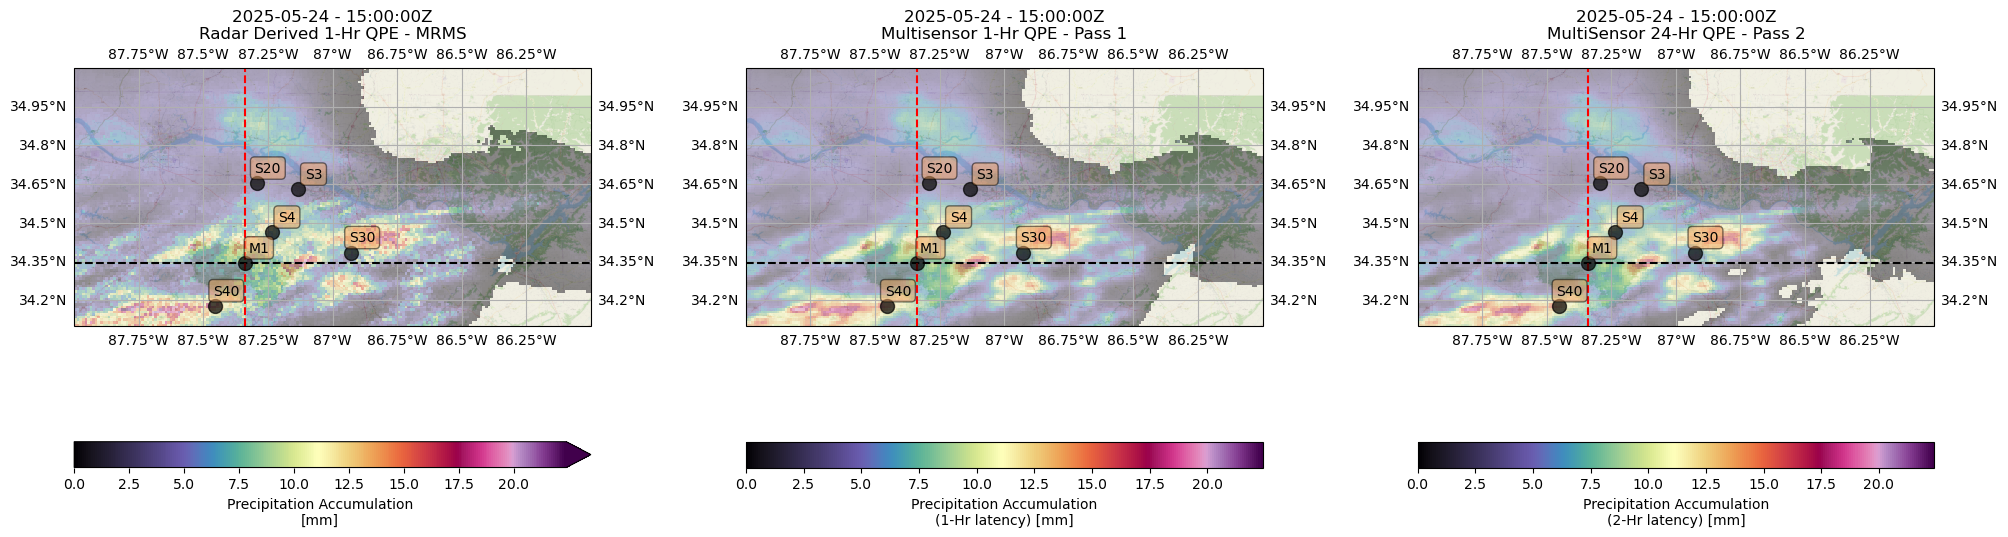

In [93]:
#---------------------------------------------------
# Define the Figure for Detailed Subplot Placement
#---------------------------------------------------
fig = plt.figure(figsize=(24, 10))
tiler = OSM()
mercator = tiler.crs
ax = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())

# adjust the subplot widths
plt.subplots_adjust(wspace=0.3)

# Find the maximum value at each position
da_max = ds_merged.isel(time=-1).radar_qpe_1hr.max()

# Find the minimum value at each position
da_min = 0

# ---------------------------------------------
# Display the Radar Precipitation Accumulation
# ---------------------------------------------

## subset the data
ds_merged.isel(time=15).radar_qpe_1hr.plot(transform=ccrs.PlateCarree(),
                                           ax=ax,
                                           cmap="ChaseSpectral",
                                           vmin=da_min,
                                           vmax=da_max,
                                           cbar_kwargs={"location" : "bottom"})

# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.add_image(tiler, 12, zorder=1, alpha=0.55)
ax.gridlines(draw_labels=True)

# Set plot bounds
ax.set_extent(bnf_domain)

# add in crosshairs to indicate the lat/lon slices
ax.axhline(y=global_sites["M1"][0], color="black", linestyle="--")
ax.axvline(x=global_sites["M1"][1], color="red", linestyle="--")

# Display the location of the BNF supplementarly sites
for key in global_sites:
    # Add a marker for the BNF sites.
    ax.plot(global_sites[key][1], 
            global_sites[key][0], 
            marker='o', 
            color='black', 
            markersize=10, 
            alpha=0.7, 
            transform=ccrs.PlateCarree())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

    # Add text to the right of the symbol.
    ax.text(global_sites[key][1]-0.1, 
            global_sites[key][0], 
            key, 
            verticalalignment='center', 
            horizontalalignment='right', 
            transform=text_transform,
            bbox=dict(facecolor='sandybrown', 
            alpha=0.5, 
            boxstyle='round'))
    
# update the title of the display
ax.set_title(np.datetime_as_string(ds_merged['valid_time'].isel(time=15).data, unit='s').replace("T", " - ") + 
             "Z\n" + "Radar Derived 1-Hr QPE - MRMS")

# ----------------------------
# Display the Multisensor QPE
# ----------------------------
## subset the data
ax1 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
ds_merged.isel(time=15).multisensor_qpe_1hr.plot(transform=ccrs.PlateCarree(),
                                                 ax=ax1,
                                                 cmap="ChaseSpectral",
                                                 vmin=da_min,
                                                 vmax=da_max,
                                                 cbar_kwargs={"location" : "bottom"})

# Add some various map elements to the plot to make it recognizable.
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.BORDERS)
ax1.add_image(tiler, 12, zorder=1, alpha=0.55)
ax1.gridlines(draw_labels=True)

# Set plot bounds
ax1.set_extent(bnf_domain)

# add in crosshairs to indicate the lat/lon slices
ax1.axhline(y=global_sites["M1"][0], color="black", linestyle="--")
ax1.axvline(x=global_sites["M1"][1], color="red", linestyle="--")

# Display the location of the BNF Supplementary Site
for key in global_sites:
    # Add a marker for the BNF sites.
    ax1.plot(global_sites[key][1], 
            global_sites[key][0], 
            marker='o', 
            color='black', 
            markersize=10, 
            alpha=0.7, 
            transform=ccrs.PlateCarree())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax1)
    text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)


    # Add text to the right of the site marker.
    ax1.text(global_sites[key][1]-0.1, 
             global_sites[key][0], 
             key, 
             verticalalignment='center', 
             horizontalalignment='right', 
             transform=text_transform,
             bbox=dict(facecolor='sandybrown', 
             alpha=0.5, 
             boxstyle='round')
    )
    
# update the title of the display
ax1.set_title(np.datetime_as_string(ds_merged['valid_time'].isel(time=15).data, unit='s').replace("T", " - ") + 
             "Z\n" + "Multisensor 1-Hr QPE - Pass 1")

# ----------------------------
# Display the QPE Difference
# ----------------------------
## subset the data
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
ds_merged.isel(time=15).multisensor_qpe_pass2.plot(transform=ccrs.PlateCarree(),
                                                   ax=ax3,
                                                   cmap="ChaseSpectral",
                                                   vmin=da_min,
                                                   vmax=da_max,
                                                   cbar_kwargs={"location" : "bottom"})

# Add some various map elements to the plot to make it recognizable.
ax3.add_feature(cfeature.LAND)
ax3.add_feature(cfeature.OCEAN)
ax3.add_feature(cfeature.BORDERS)
ax3.add_image(tiler, 12, zorder=1, alpha=0.55)
ax3.gridlines(draw_labels=True)

# Set plot bounds
ax3.set_extent(bnf_domain)

# add in crosshairs to indicate the lat/lon slices
ax3.axhline(y=global_sites["M1"][0], color="black", linestyle="--")
ax3.axvline(x=global_sites["M1"][1], color="red", linestyle="--")

# Display the location of the BNF Supplementary Sites
for key in global_sites:
    # Add a marker for the BNF sites.
    ax3.plot(global_sites[key][1], 
            global_sites[key][0], 
            marker='o', 
            color='black', 
            markersize=10, 
            alpha=0.7, 
            transform=ccrs.PlateCarree())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax3)
    text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

    # Add text to the right of the site marker.
    ax3.text(global_sites[key][1]-0.1, 
             global_sites[key][0], 
             key, 
             verticalalignment='center', 
             horizontalalignment='right', 
             transform=text_transform,
             bbox=dict(facecolor='sandybrown', 
             alpha=0.5, 
             boxstyle='round'))
    
# update the title of the display
ax3.set_title(np.datetime_as_string(ds_merged['valid_time'].isel(time=15).data, unit='s').replace("T", " - ") + 
             "Z\n" + "MultiSensor 24-Hr QPE - Pass 2")